<a href="https://colab.research.google.com/github/awaiskhan005/DATA-SCIENCE-AND-AI-/blob/main/crypto_price_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Function to fetch and prepare data for multiple tickers
def fetch_and_prepare_data(tickers, start_date, end_date):
    combined_data = pd.DataFrame()

    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)
        data.ffill(inplace=True)  # Forward fill any null values
        data = data[['Close']].rename(columns={'Close': ticker})

        if combined_data.empty:
            combined_data = data
        else:
            combined_data = combined_data.join(data, how='outer')

    combined_data.ffill(inplace=True)  # Forward fill any remaining null values after join
    return combined_data


In [4]:
# Example usage
tickers = ['BTC-USD', 'ETH-USD', 'LTC-USD']
start_date = '2020-01-01'
end_date = '2024-09-20'
data = fetch_and_prepare_data(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Function to normalize data
def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data, scaler

# Normalize data
normalized_data, scaler = normalize_data(data)


In [6]:
# Function to create a dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step, 0])  # Predict the first coin (e.g., BTC-USD)
    return np.array(X), np.array(Y)

# Create dataset
time_step = 60
X, Y = create_dataset(normalized_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], len(tickers))  # Reshape for LSTM input


In [7]:
# Function to build LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))  # Predict the price of the first coin
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train the model
model = build_model((time_step, len(tickers)))
model.fit(X, Y, batch_size=1, epochs=50)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 47s 27ms/step - loss: 0.0065
Epoch 2/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - loss: 0.0015
Epoch 3/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 83s 28ms/step - loss: 0.0011
Epoch 4/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 80s 27ms/step - loss: 8.8388e-04
Epoch 5/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - loss: 9.8605e-04
Epoch 6/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - loss: 6.6022e-04
Epoch 7/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - loss: 7.2076e-04
Epoch 8/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 80s 27ms/step - loss: 6.7632e-04
Epoch 9/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - loss: 6.2538e-04
Epoch 10/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - loss: 6.0826e-04
Epoch 11/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - loss: 5.6531e-04
Epoch 12/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - loss: 6.1155e-04
Epoch 13/50
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - loss: 6.1249e-04
Epoch 14/50
1663/1663 ━━━━━━━━━━━

In [16]:
def update_model_with_real_time_data(model, scaler, tickers, time_step=60):
    new_data = {}

    for ticker in tickers:
        new_data[ticker] = yf.download(ticker, period='1d', interval='5m')['Close']

    new_data = pd.DataFrame(new_data).ffill().values

    if new_data.shape[0] <= time_step:
        print("Not enough data to update the model.")
        return

    normalized_new_data = scaler.transform(new_data)

    for i in range(len(normalized_new_data) - time_step - 1):
        x = normalized_new_data[i:(i + time_step)]
        x = x.reshape(1, time_step, len(tickers))
        y = normalized_new_data[i + time_step, 0]

        model.train_on_batch(x, np.array([y]))

# Example usage for real-time data update
update_model_with_real_time_data(model, scaler, tickers)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63057.43359375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted price for BTC-USD: 63052.65234375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted price for BTC-USD: 63050.43359375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for BTC-USD: 63050.44140625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Predicted price for BTC-USD: 63059.81640625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted price for BTC-USD: 63056.5546875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted price for BTC-USD: 63061.34375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63061.34375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted price for BTC-USD: 63063.3203125


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for BTC-USD: 63056.91796875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63055.8046875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for BTC-USD: 63040.16796875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63019.1328125


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for BTC-USD: 63023.07421875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted price for BTC-USD: 63019.21875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63019.1015625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63007.9375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63006.7265625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for BTC-USD: 63006.71484375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63013.90234375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted price for BTC-USD: 63023.41015625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63017.859375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted price for BTC-USD: 63014.04296875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted price for BTC-USD: 63014.04296875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted price for BTC-USD: 62998.71484375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for BTC-USD: 63015.9921875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63021.66796875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted price for BTC-USD: 63022.5390625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted price for BTC-USD: 63039.64453125


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63034.94140625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63034.90625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted price for BTC-USD: 63034.90625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63045.56640625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted price for BTC-USD: 63049.41015625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63034.40234375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63045.19921875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63017.78515625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63017.66015625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for BTC-USD: 63017.73046875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted price for BTC-USD: 63008.65625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted price for BTC-USD: 63008.421875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 62990.05859375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted price for BTC-USD: 63008.60546875


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted price for BTC-USD: 63004.37109375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted price for BTC-USD: 63004.37109375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for BTC-USD: 63015.390625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted price for BTC-USD: 63015.390625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63022.93359375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted price for BTC-USD: 63006.51953125


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted price for BTC-USD: 63015.72265625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted price for BTC-USD: 63007.984375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted price for BTC-USD: 63003.2578125


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63011.77734375


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63011.59765625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted price for BTC-USD: 63010.26953125


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for BTC-USD: 63009.91015625


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for BTC-USD: 63011.58203125


KeyboardInterrupt: 

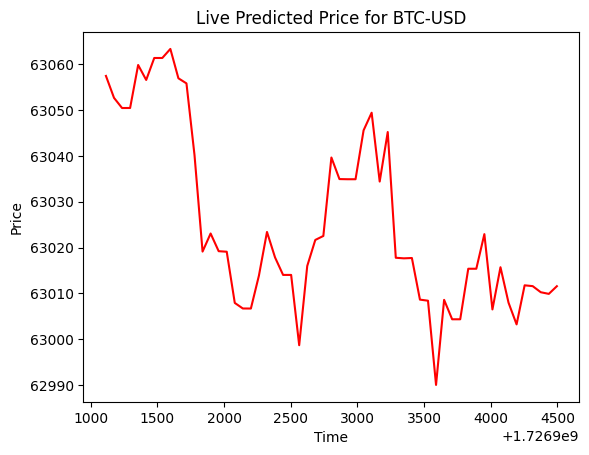

In [20]:
# prompt: can we make a live visual fro the above prediction with should indicate live predicted values

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import time

# ... (Your existing code for fetching, preparing, normalizing data, building and training the model) ...

def make_trading_decision(model, scaler, tickers, time_step=60):
    plt.ion()  # Turn on interactive mode for live plotting
    fig, ax = plt.subplots()
    line, = ax.plot([], [], 'r-')  # Initialize an empty plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title(f'Live Predicted Price for {tickers[0]}')
    x_data = []
    y_data = []

    while True:
        new_data = {}

        for ticker in tickers:
            new_data[ticker] = yf.download(ticker, period='1d', interval='5m')['Close']

        new_data = pd.DataFrame(new_data).ffill().values

        if new_data.shape[0] <= time_step:
            print("Not enough data to make a prediction.")
            continue

        normalized_new_data = scaler.transform(new_data)

        # Predict the next price
        x = normalized_new_data[-time_step:]
        x = x.reshape(1, time_step, len(tickers))
        predicted_price_normalized = model.predict(x)

        # Reshape the predicted price to match scaler input shape
        predicted_price_normalized = predicted_price_normalized.reshape(-1, 1)

        # Inverse transform to get the actual price
        predicted_price = scaler.inverse_transform(np.tile(predicted_price_normalized, (1, len(tickers))))

        # Update plot data
        x_data.append(time.time())  # Use timestamp for x-axis
        y_data.append(predicted_price[0][0])

        # Update the plot
        line.set_data(x_data, y_data)
        ax.relim()  # Recalculate limits
        ax.autoscale_view()  # Autoscale the view
        fig.canvas.draw()
        fig.canvas.flush_events()  # Update the plot on the screen

        print(f"Predicted price for {tickers[0]}: {predicted_price[0][0]}")

        # Sleep for a minute before the next prediction
        time.sleep(60)

# Start the trading bot with live visualization
make_trading_decision(model, scaler, tickers)


In [2]:
pip install --upgrade yfinance


In [3]:
start_date = '2023-01-01'
end_date = '2023-12-31'


In [8]:
# Try fetching data for a single ticker with a shorter date range
data = yf.download('BTC-USD', start='2023-01-01', end='2024-09-21', interval='1h')
print(data)


[*********************100%***********************]  1 of 1 completed

                                   Open          High           Low  \
Datetime                                                              
2023-01-01 00:00:00+00:00  16547.914062  16553.699219  16529.074219   
2023-01-01 01:00:00+00:00  16538.013672  16556.140625  16536.416016   
2023-01-01 02:00:00+00:00  16556.494141  16564.591797  16549.503906   
2023-01-01 03:00:00+00:00  16557.521484  16557.912109  16540.302734   
2023-01-01 04:00:00+00:00  16546.429688  16548.511719  16528.251953   
...                                 ...           ...           ...   
2024-09-20 19:00:00+00:00  62867.640625  63024.007812  62822.484375   
2024-09-20 20:00:00+00:00  62823.800781  62936.468750  62733.792969   
2024-09-20 21:00:00+00:00  62827.171875  63285.917969  62827.171875   
2024-09-20 22:00:00+00:00  63129.722656  63276.875000  63129.722656   
2024-09-20 23:00:00+00:00  63185.585938  63198.402344  63084.996094   

                                  Close     Adj Close     Volume  
Datetime 

In [9]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-01-01 00:00:00+00:00,16547.914062,16553.699219,16529.074219,16539.396484,16539.396484,0
2023-01-01 01:00:00+00:00,16538.013672,16556.140625,16536.416016,16556.140625,16556.140625,0
2023-01-01 02:00:00+00:00,16556.494141,16564.591797,16549.503906,16557.580078,16557.580078,0
2023-01-01 03:00:00+00:00,16557.521484,16557.912109,16540.302734,16548.863281,16548.863281,0
2023-01-01 04:00:00+00:00,16546.429688,16548.511719,16528.251953,16530.708984,16530.708984,16758784


In [3]:
# Install yfinance if not already installed
# !pip install yfinance --upgrade --no-cache-dir
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [4]:
# Define the date range
start_date = '2023-01-01'
end_date = '2024-09-21'

# Fetch hourly data for BTC-USD
data = yf.download('BTC-USD', start=start_date, end=end_date, interval='1h')

# Display the first few rows of the dataset
print(data.head())


[*********************100%***********************]  1 of 1 completed

                                   Open          High           Low  \
Datetime                                                              
2023-01-01 00:00:00+00:00  16547.914062  16553.699219  16529.074219   
2023-01-01 01:00:00+00:00  16538.013672  16556.140625  16536.416016   
2023-01-01 02:00:00+00:00  16556.494141  16564.591797  16549.503906   
2023-01-01 03:00:00+00:00  16557.521484  16557.912109  16540.302734   
2023-01-01 04:00:00+00:00  16546.429688  16548.511719  16528.251953   

                                  Close     Adj Close    Volume  
Datetime                                                         
2023-01-01 00:00:00+00:00  16539.396484  16539.396484         0  
2023-01-01 01:00:00+00:00  16556.140625  16556.140625         0  
2023-01-01 02:00:00+00:00  16557.580078  16557.580078         0  
2023-01-01 03:00:00+00:00  16548.863281  16548.863281         0  
2023-01-01 04:00:00+00:00  16530.708984  16530.708984  16758784  


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-01-01 00:00:00+00:00,16547.914062,16553.699219,16529.074219,16539.396484,16539.396484,0
2023-01-01 01:00:00+00:00,16538.013672,16556.140625,16536.416016,16556.140625,16556.140625,0
2023-01-01 02:00:00+00:00,16556.494141,16564.591797,16549.503906,16557.580078,16557.580078,0
2023-01-01 03:00:00+00:00,16557.521484,16557.912109,16540.302734,16548.863281,16548.863281,0
2023-01-01 04:00:00+00:00,16546.429688,16548.511719,16528.251953,16530.708984,16530.708984,16758784


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


                                   Open          High           Low  \
Datetime                                                              
2023-01-01 00:00:00+00:00  16547.914062  16553.699219  16529.074219   
2023-01-01 01:00:00+00:00  16538.013672  16556.140625  16536.416016   
2023-01-01 02:00:00+00:00  16556.494141  16564.591797  16549.503906   
2023-01-01 03:00:00+00:00  16557.521484  16557.912109  16540.302734   
2023-01-01 04:00:00+00:00  16546.429688  16548.511719  16528.251953   

                                  Close     Adj Close    Volume  
Datetime                                                         
2023-01-01 00:00:00+00:00  16539.396484  16539.396484         0  
2023-01-01 01:00:00+00:00  16556.140625  16556.140625         0  
2023-01-01 02:00:00+00:00  16557.580078  16557.580078         0  
2023-01-01 03:00:00+00:00  16548.863281  16548.863281         0  
2023-01-01 04:00:00+00:00  16530.708984  16530.708984  16758784  
Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 

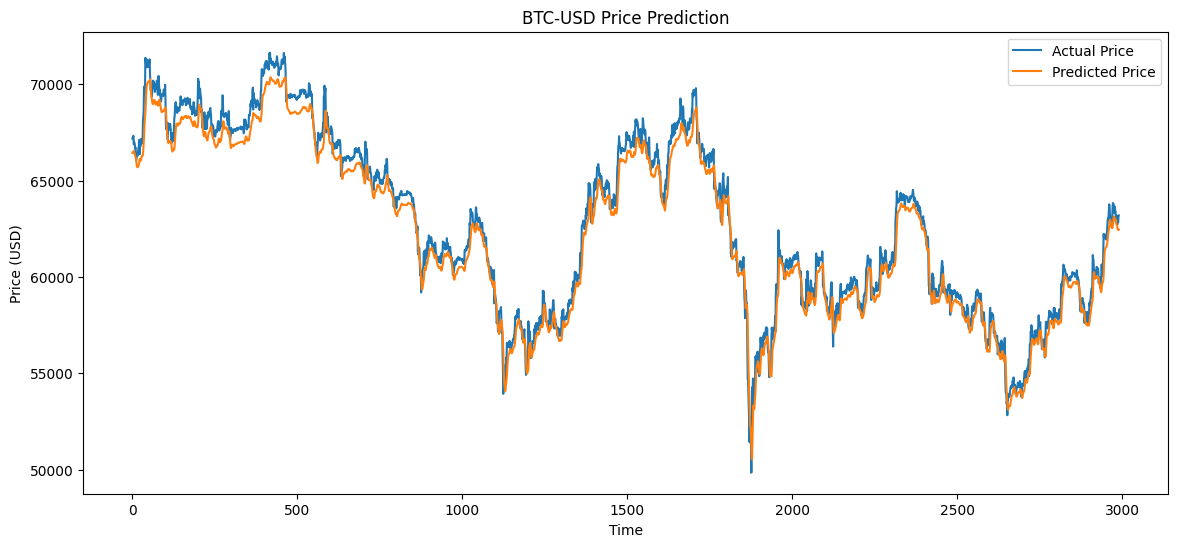

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the date range
start_date = '2023-01-01'
end_date = '2024-09-21'

# Fetch hourly data for BTC-USD
data = yf.download('BTC-USD', start=start_date, end=end_date, interval='1h')

# Display the first few rows of the dataset
print(data.head())

# Data Preprocessing: Extract the 'Close' price and normalize the data
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Function to create dataset for LSTM
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i+time_step, 0])
        Y.append(data[i+time_step, 0])
    return np.array(X), np.array(Y)

# Prepare the dataset with 60 time steps
time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# Reshape the input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))  # Final output for predicting the closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=32, epochs=50)

# Make predictions on the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual values

# Inverse scaling of the true test values
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Plot the results: predicted vs actual BTC-USD prices
plt.figure(figsize=(14, 6))
plt.plot(Y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('BTC-USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [8]:
# Use the last 60 data points from the normalized data to predict the next hour
last_60_data = scaled_data[-time_step:].reshape(1, time_step, 1) # Use scaled_data instead of normalized_data

# Predict the next hour's price
next_hour_prediction = model.predict(last_60_data)

# Inverse the normalization to get the actual price
next_hour_prediction = scaler.inverse_transform(next_hour_prediction)

print(f"Predicted BTC-USD Price for the next hour: {next_hour_prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted BTC-USD Price for the next hour: 62575.27734375
